# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np

try:
  import lightgbm as lgb
except:
  !pip install lightgbm
  import lightgbm as lgb
  
try:
  import shap
except:
  !pip install shap
  import shap

try:
  from umap import UMAP
except:
  !pip install umap
  !pip install umap-learn
  from umap import UMAP

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-10-13 19:46:08.875733: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 19:46:08.931863: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 19:46:08.932826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:46:09.906808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Carga de archivos para análisis local

In [9]:
lgbm_importancia = pd.read_pickle("../../normanbuck/datasets/lgbm_importancia_02.pkl")
shap_bajas = pd.read_pickle("../../normanbuck/datasets/shap_bajas_02.pkl")

ds_bajas = pd.read_pickle("../../normanbuck/datasets/competencia_02_eng_bajas.pkl")

In [10]:
with open("../../normanbuck/datasets/shap_values_02", "rb") as fp:   # Unpickling
  shap_values = pickle.load(fp)

In [18]:
p_bajas = np.load("../../normanbuck/datasets/p_bajas_02.npy")

## Continuo el análisis local

In [31]:
lgbm_importancia[:15]

,Features,Importances
0,foto_mes,425
48,cpayroll_trx,135
131,Visa_Finiciomora,113
154,actividad,105
30,mprestamos_personales,105
153,mtarjeta_consumo,97
17,mcaja_ahorro,74
16,ccaja_ahorro,71
266,actividad_dn6,70
103,ctrx_quarter,69


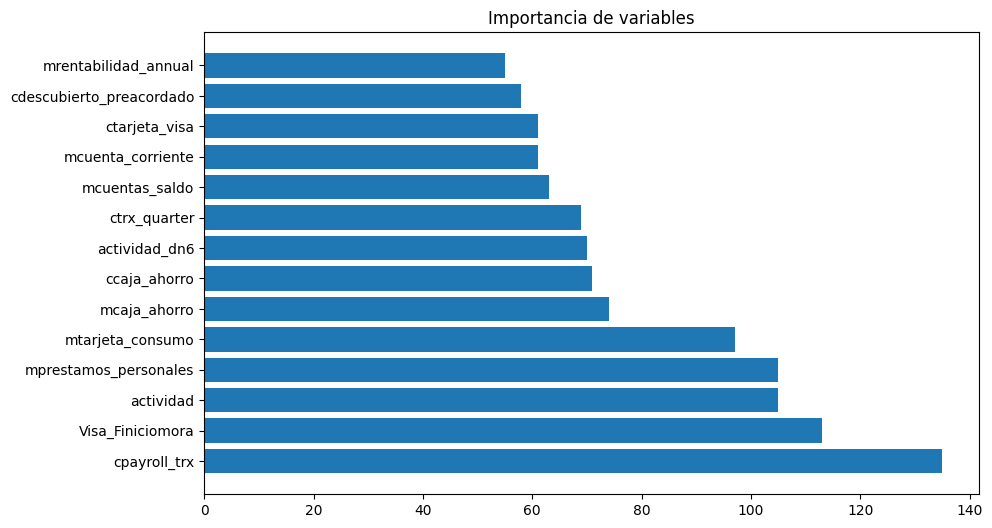

In [35]:
# barplot de importancia de variables
plt.figure(figsize=(10, 6))
plt.title("Importancia de variables")
ax = plt.barh(lgbm_importancia[1:15].Features, lgbm_importancia[1:15].Importances)
plt.show()

En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [19]:
# busco un caso en p_bajas, con un p alta, y tomo su índice
cliente_idx = 7 # el 
print(p_bajas[cliente_idx])

0.03236850534919954


En la columna de la izquierda es el valor de la variable, la importancia es la columna derecha.
Cuanto más positivo ese parámetro es más determinate a que se produzca la baja+2, uno negativo es que hace menos probable la baja.

In [12]:
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
# pd.concat([ds_bajas.iloc[7], shap_bajas.iloc[7]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

,2320,7
foto_mes,202008.000000,0.738620
mcuentas_saldo,12886.820000,0.092998
mtarjeta_consumo_dn6,0.861463,0.060039
mcuentas_otras_neg,0.000000,0.035104
internet,1.000000,0.034588
...,...,...
cdescubierto_preacordado,0.000000,-0.182298
cpayroll_trx_min6,0.000000,-0.210206
cpayroll_trx,0.000000,-0.353687
mcaja_ahorro,770.430000,-0.379815


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [40]:
shap_bajas_neu = shap_bajas.drop('foto_mes', axis= 1)
shap_bajas_neu.head(10)

,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,cplazo_fijo_l4,cplazo_fijo_l5,cplazo_fijo_l6,cplazo_fijo_d1,cplazo_fijo_d2,cplazo_fijo_d3,cplazo_fijo_d4,cplazo_fijo_d5,cplazo_fijo_d6,cplazo_fijo_dn6
0,-0.000331,0.0,-0.039609,0.0,0.000214,-0.008259,0.108799,-0.000559,-0.015757,-0.008697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000556
1,-0.000830,0.0,-0.054147,0.0,0.000709,-0.029682,-0.067572,-0.010968,-0.030763,-0.023880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000219
2,-0.001543,0.0,-0.068062,0.0,0.000402,-0.002229,-0.023751,-0.004556,-0.011862,-0.008797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002913
3,-0.000920,0.0,-0.048929,0.0,0.000709,0.002261,-0.025813,0.000446,-0.004915,-0.012732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003377
4,0.005472,0.0,-0.045540,0.0,0.000402,0.008265,-0.016937,0.000420,-0.004543,-0.008850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001507
5,-0.001551,0.0,-0.047082,0.0,0.000402,-0.008290,-0.010892,0.000420,0.002842,-0.007978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001432
6,-0.002276,0.0,0.019706,0.0,0.000402,-0.001045,0.005973,0.000058,-0.002261,-0.001284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000723
7,-0.000245,0.0,0.034588,0.0,0.000214,0.000536,0.018022,0.000152,-0.013293,-0.015555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001168
8,-0.001123,0.0,-0.049789,0.0,0.000402,-0.000932,-0.009482,-0.000060,-0.007560,-0.010128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001721
9,0.005472,0.0,-0.043590,0.0,-0.000902,0.005688,-0.024756,0.000744,-0.009502,-0.007082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002431


In [42]:
shap_bajas_neu.mean().sort_values(ascending=True)

ctrx_quarter                 -0.665541
cpayroll_trx                 -0.299518
actividad                    -0.231919
mcaja_ahorro                 -0.193962
cpayroll_trx_min6            -0.151955
                                ...   
mcaja_ahorro_min6             0.000219
ctransferencias_emitidas      0.000352
chomebanking_transacciones    0.001169
thomebanking                  0.001500
mtransferencias_emitidas      0.001822
Length: 506, dtype: float64

In [13]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

ctrx_quarter               0.732143
foto_mes                   0.611934
cpayroll_trx               0.349514
actividad                  0.271146
mcaja_ahorro               0.234814
                             ...   
mcaja_ahorro_dolares_l6    0.000000
mcaja_ahorro_dolares_l5    0.000000
mcaja_ahorro_dolares_l4    0.000000
mcaja_ahorro_dolares_l3    0.000000
mautoservicio_d3           0.000000
Length: 507, dtype: float64

La biblioteca contiene útiles herramientas para vizualizar la info anterior.

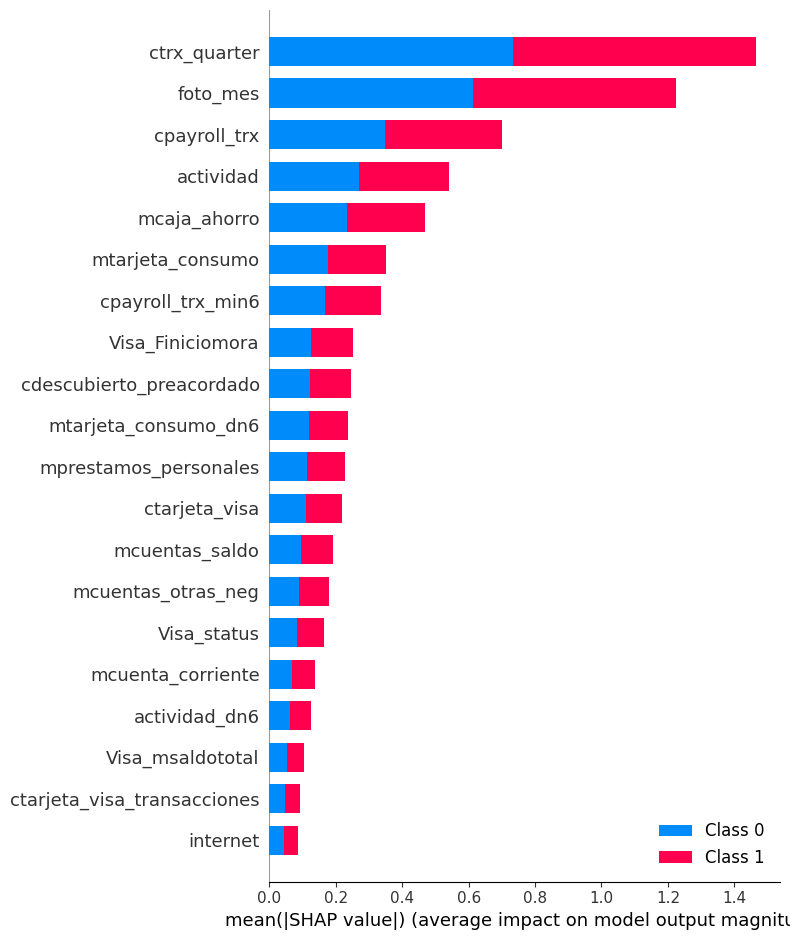

In [45]:
shap.summary_plot(shap_values, ds_bajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

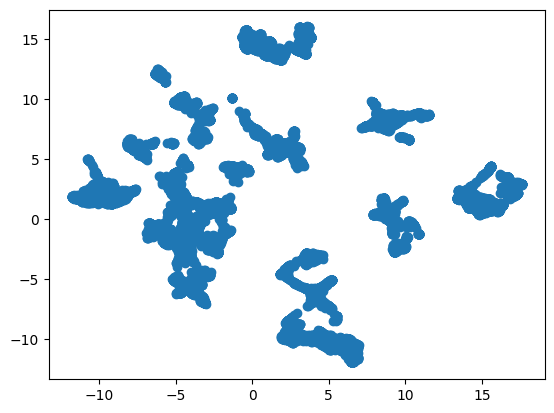

In [15]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([11197.,  2940.,  1643.,  1009.,   599.,   411.,   371.,   307.,
          266.,   187.]),
 array([0.00094852, 0.09066936, 0.18039021, 0.27011106, 0.3598319 ,
        0.44955275, 0.5392736 , 0.62899445, 0.71871529, 0.80843614,
        0.89815699]),
 <BarContainer object of 10 artists>)

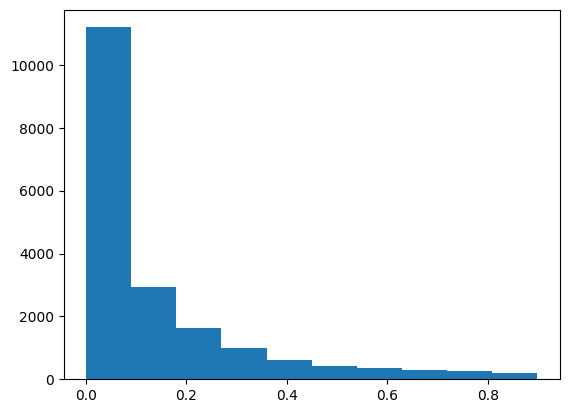

In [20]:
# p_bajas = gbm.predict(ds_bajas)
plt.hist(p_bajas)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

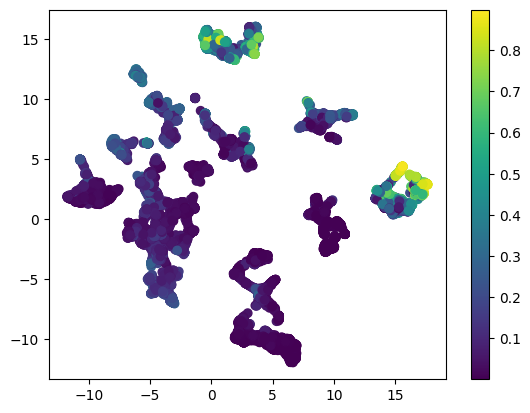

In [21]:
# mayor probabilidades de baja+2 mostrada en escala de colores
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()

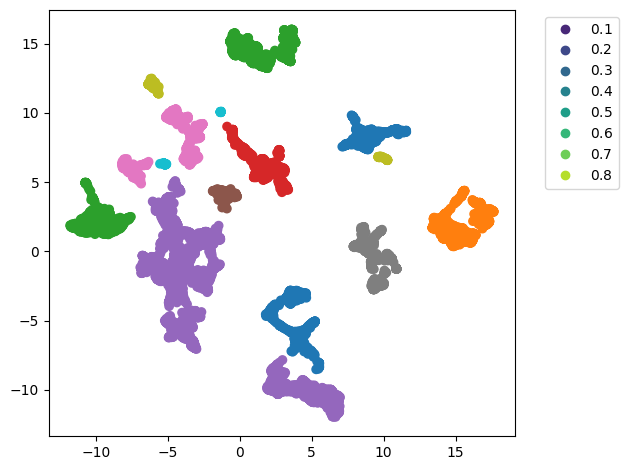

In [22]:
hdb = DBSCAN(eps=0.75)
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap='tab10')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [23]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

foto_mes                 0.563440
mprestamos_personales    0.029630
Visa_msaldototal         0.010138
ctarjeta_visa            0.007781
Visa_status              0.007516
                           ...   
mcuentas_saldo          -0.161787
ctrx_quarter            -0.303066
cpayroll_trx            -0.319474
mcaja_ahorro            -0.464563
Visa_Finiciomora        -1.487931
Length: 507, dtype: float64

In [24]:
shap_bajas[y.labels_ == 6].mean().sort_values(ascending=False)

foto_mes                    0.654024
cdescubierto_preacordado    0.033768
Visa_status                 0.014390
ctarjeta_visa               0.011514
thomebanking                0.006749
                              ...   
cpayroll_trx_min6          -0.190255
mcaja_ahorro               -0.205962
cpayroll_trx               -0.316508
actividad                  -0.472537
ctrx_quarter               -0.955319
Length: 507, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

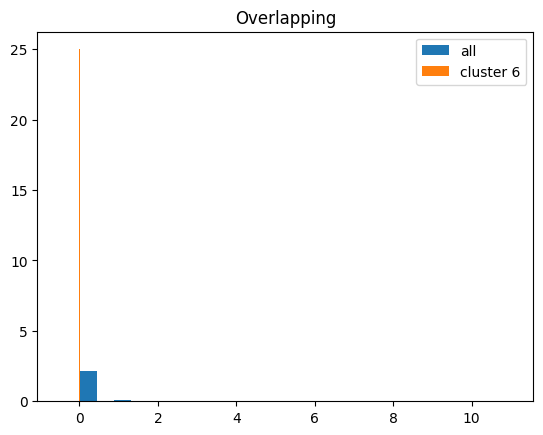

In [25]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 6]["cpayroll_trx"], label='cluster 6', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

In [26]:
ds_bajas.loc[y.labels_ == 1]["cprestamos_personales"].mean()

1.5953757225433527

In [27]:
ds_bajas.loc[y.labels_ == 5]["cprestamos_personales"].mean()

1.6983050847457628

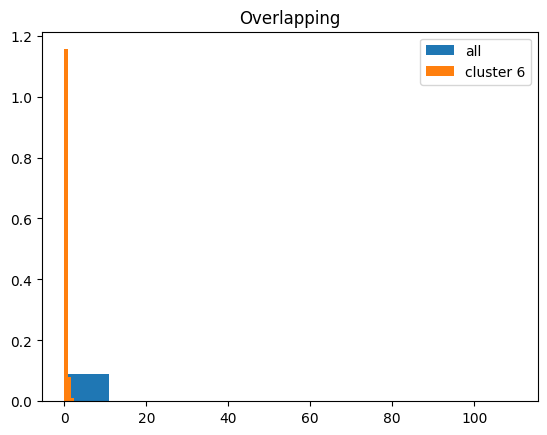

In [28]:
plt.hist(ds_bajas.loc[:]["cprestamos_personales"], label='all', density=True)
plt.hist(ds_bajas.loc[y.labels_ == 6]["cprestamos_personales"], label='cluster 6', density=True)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()